# **Preparation**


## **Import Library**

In [ ]:
# Install
!pip install PyDOE
!pip install tensorflow==1.15

In [6]:
# Import
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import scipy.io
import tensorflow as tf
import time
import timeit
import math as m
import scipy.interpolate

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE import lhs


In [7]:
import matplotlib.pyplot as plt
import numpy as np

## **Class & Functions**

### **PINN Class**

In [2]:
class Pinn:

    def __init__(self, data, params, problem_type, skip_connection=False, exist_model=False, file_dir=""):
        # Initialize & Unpack Input data
        self.problem_type = problem_type
        self.unpack(data, params)
        self.initialize_variables()
        self.skip_connection = skip_connection

        # Initialize Neural Network Computational Graph
        # Weight & biases
        if exist_model:
            print("Loading NN parameters ...")
            self.weights, self.biases = self.load_model(file_dir)
        else:
            self.weights, self.biases = self.initialize_network()

        # Placeholder & Graph
        # Placeholder (where we put input)
        self.initialize_placeholders()

        # Computational graph of Physics-Informed
        self.graph_network()

        # Computational graph of loss
        self.graph_loss()

        # Optimizers
        self.initialize_optimizers()

        # Session
        self.initialize_session()

    def callback_direct(self, loss_test, loss_total, loss_collo, loss_meu, loss_init):
        self.count += 1
        self.loss_test_log.append(loss_test)
        self.loss_total_log.append(loss_total)
        self.loss_collo_log.append(loss_collo)
        self.loss_meu_log.append(loss_meu)
        self.loss_init_log.append(loss_init)
        
        if self.count % self.verboses_newton == 0:    
            print("iter: %d, Loss Test: %.4e, Loss Total: %.4e, Loss Collo: %.4e, Loss Measurement: %.4e, Loss Init: %.4e" %
                 (self.count, loss_test, loss_total, loss_collo, loss_meu, loss_init))

    def normalize_input_data(self):
        # Normalize data
        x_c = self.normalize_data(data=self.x_c, axis="x")
        t_c = self.normalize_data(data=self.t_c, axis="t")
        x_left = self.normalize_data(data=self.x_left, axis="x")
        t_left = self.normalize_data(data=self.t_left, axis="t")
        x_right = self.normalize_data(data=self.x_right, axis="x")
        t_right = self.normalize_data(data=self.t_right, axis="t")
        x_initial = self.normalize_data(data=self.x_initial, axis="x")
        t_initial = self.normalize_data(data=self.t_initial, axis="t")
        x_test = self.normalize_data(data=self.x_test, axis="x")
        t_test = self.normalize_data(data=self.t_test, axis="t")

        return x_c, t_c, x_left, t_left, x_right, t_right, x_initial, t_initial, x_test, t_test

    def fit_newton(self):
        # Change flag
        self.newton_started = True
        self.count += 0

        # Normalize data
        if len(self.loc_num) > 2:
            (x_c, t_c, 
             x_left, t_left, 
             x_right, t_right,
             x_initial, t_initial, 
             x_test, t_test) = self.normalize_input_data()
            
            x_meu = self.normalize_data(data=self.x_meu, axis="x")
            t_meu = self.normalize_data(data=self.t_meu, axis="t")

            # Create dictionary
            tf_dict = {self.x_c_tf: x_c, self.t_c_tf: t_c,                              # collocation data
                       self.x_left_tf: x_left, self.t_left_tf: t_left,                  # left data (pts)
                       self.u_left_tf: self.u_left, 
                       self.x_right_tf: x_right, self.t_right_tf: t_right,              # right data
                       self.u_right_tf: self.u_right,
                       self.x_meu_tf: x_meu, self.t_meu_tf: t_meu,                      # right data
                       self.u_meu_tf: self.u_meu,
                       self.x_initial_tf: x_initial, self.t_initial_tf: t_initial,      # initial data
                       self.u_initial_tf: self.u_initial, 
                       self.x_test_tf: x_test, self.t_test_tf: t_test,                  # test data
                       self.u_test_tf:self.u_test}
        else:
            (x_c, t_c, 
             x_left, t_left, 
             x_right, t_right,
             x_initial, t_initial, 
             x_test, t_test) = self.normalize_input_data()

            # Create dictionary
            tf_dict = {self.x_c_tf: x_c, self.t_c_tf: t_c,                              # collocation data
                       self.x_left_tf: x_left, self.t_left_tf: t_left,                  # left data (pts)
                       self.u_left_tf: self.u_left, 
                       self.x_right_tf: x_right, self.t_right_tf: t_right,              # right data
                       self.u_right_tf: self.u_right,
                       self.x_initial_tf: x_initial, self.t_initial_tf: t_initial,      # initial data
                       self.u_initial_tf: self.u_initial, 
                       self.x_test_tf: x_test, self.t_test_tf: t_test,                  # test data
                       self.u_test_tf:self.u_test}

        # Optimize
        self.train_op_newton.minimize(self.sess,
                                      feed_dict=tf_dict,
                                      fetches=[self.loss_test, self.loss_total, 
                                              self.loss_collo, self.loss_meu, self.loss_initial],
                                      loss_callback=self.callback_direct)
    
    def graph_loss(self):
        # Test
        self.loss_test = tf.math.sqrt(tf.reduce_mean(tf.square(self.u_test_tf - self.u_test_pred)))
        
        # Collocation points
        self.loss_collo = tf.reduce_mean(tf.square(self.f_pred_u))
        
        # Boundary
        self.loss_left = tf.reduce_mean(tf.square(self.u_left_pred-self.u_left_tf)) 
        self.loss_right = tf.reduce_mean(tf.square(self.u_right_pred-self.u_right_tf))

        # initial: u & v to dirichlet conditions
        self.loss_initial = tf.reduce_mean(tf.square(self.u_initial_pred-self.u_initial_tf)) 
        
        self.loss_bound = (self.loss_left + self.loss_right)
        self.loss_initial = self.loss_initial
        
        if len(self.loc_num) > 2:
            self.loss_meu = tf.reduce_mean(tf.square(self.u_meu_pred - self.u_meu_tf))
            self.loss_meu = self.loss_bound + self.loss_meu
        else:
            self.loss_meu = self.loss_bound

        # Total loss
        self.loss_total = self.loss_collo + self.loss_meu + self.loss_initial

    def graph_network(self):
        if self.problem_type == "Inverse":
            # Test data
            (self.u_test_pred, _) = self.net_dnn(self.x_test_tf, self.t_test_tf)
            # Predict data
            (self.u_pred, self.lambda_pred) = self.net_dnn(self.x_tf, self.t_tf)
            # Collocation points
            (self.f_pred_u) = self.net_physics(self.x_c_tf, self.t_c_tf)
            # left
            (self.u_left_pred, _) = self.net_dnn(self.x_left_tf, self.t_left_tf)
            # right
            (self.u_right_pred, _) = self.net_dnn(self.x_right_tf, self.t_right_tf)
            if len(self.loc_num) > 2:
                (self.u_meu_pred, _) = self.net_dnn(self.x_meu_tf, self.t_meu_tf)
            # Initial
            (self.u_initial_pred, _) = self.net_dnn(self.x_initial_tf, self.t_initial_tf)
        else:
           # Test data
           (self.u_test_pred) = self.net_dnn(self.x_test_tf, self.t_test_tf)
           # Predict data
           (self.u_pred) = self.net_dnn(self.x_tf, self.t_tf)
           # Collocation points
           (self.f_pred_u) = self.net_physics(self.x_c_tf, self.t_c_tf)
           # left
           (self.u_left_pred) = self.net_dnn(self.x_left_tf, self.t_left_tf)
           # right
           (self.u_right_pred) = self.net_dnn(self.x_right_tf, self.t_right_tf)
           # Initial
           (self.u_initial_pred) = self.net_dnn(self.x_initial_tf, self.t_initial_tf)
        
    def load_model(self, file_dir):
        weights = []
        biases = []
        num_layers = len(self.layers)
        
        with open(file_dir, 'rb') as f:
            dnn_weights, dnn_biases = pickle.load(f)

            # stored model mush has the same layers
            assert num_layers == (len(dnn_weights)+1)

            for num in range(0, num_layers-1):
                W = tf.Variable(dnn_weights[num])
                b = tf.Variable(dnn_biases[num])
                weights.append(W)
                biases.append(b)
                print('Loaded NN parameters successfully ...')

        return weights, biases

    def initialize_network(self):
        # Initialize
        weights = []
        biases = []
        num_layers = len(self.layers)
        layers = self.layers

        # Create network
        for lyr in range(num_layers-1):
            # initialize weights from Xavier initialization
            np.random.seed(self.random_seed)
            W = self.xavier_init(size=[layers[lyr], 
                                       layers[lyr+1]])

            # initialize biases = 0
            np.random.seed(self.random_seed)
            b = tf.Variable(tf.zeros([1, layers[lyr+1]],
                                     dtype=tf.float32),
                            dtype=tf.float32)

            # Append generated weights & biases to the list
            weights.append(W)
            biases.append(b)

        return weights, biases

    def initialize_optimizers(self):
        variable_list = self.weights+self.biases
        self.train_op_newton = tf.contrib.opt.ScipyOptimizerInterface(
                                    self.loss_total,
                                    var_list = variable_list,
                                    method = "L-BFGS-B",
                                    options = {"maxiter": 100000,
                                               "maxfun": 100000,
                                               "maxcor": 50,
                                               "maxls": 50,
                                               "ftol": 1*np.finfo(float).eps})

    def initialize_placeholders(self):
        # Test data
        self.x_test_tf = tf.placeholder(tf.float32, shape=[None, self.x_test.shape[1]])
        self.t_test_tf = tf.placeholder(tf.float32, shape=[None, self.t_test.shape[1]])
        self.u_test_tf = tf.placeholder(tf.float32, shape=[None, self.u_test.shape[1]])
        
        # Predict data
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x_c.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t_c.shape[1]])

        # Collocation data
        self.x_c_tf = tf.placeholder(tf.float32, shape=[None, self.x_c.shape[1]])
        self.t_c_tf = tf.placeholder(tf.float32, shape=[None, self.t_c.shape[1]])

        # Boundary data
        # left
        self.x_left_tf = tf.placeholder(tf.float32, shape=[None, self.x_left.shape[1]])
        self.t_left_tf = tf.placeholder(tf.float32, shape=[None, self.t_left.shape[1]])
        self.u_left_tf = tf.placeholder(tf.float32, shape=[None, self.u_left.shape[1]])

        # right
        self.x_right_tf = tf.placeholder(tf.float32, shape=[None, self.x_right.shape[1]])
        self.t_right_tf = tf.placeholder(tf.float32, shape=[None, self.t_right.shape[1]])
        self.u_right_tf = tf.placeholder(tf.float32, shape=[None, self.u_right.shape[1]])
        
        if len(self.loc_num) > 2:
            self.x_meu_tf = tf.placeholder(tf.float32, shape=[None, self.x_meu.shape[1]])
            self.t_meu_tf = tf.placeholder(tf.float32, shape=[None, self.t_meu.shape[1]])
            self.u_meu_tf = tf.placeholder(tf.float32, shape=[None, self.u_meu.shape[1]])
        
        # initial
        self.x_initial_tf = tf.placeholder(tf.float32, shape=[None, self.x_initial.shape[1]])
        self.t_initial_tf = tf.placeholder(tf.float32, shape=[None, self.t_initial.shape[1]])
        self.u_initial_tf = tf.placeholder(tf.float32, shape=[None, self.u_initial.shape[1]])

    def initialize_session(self):
        tf_config = tf.ConfigProto(allow_soft_placement=True,
                                   log_device_placement=True)
        self.sess = tf.Session(config=tf_config)
        # self.sess = tf.InteractiveSession(config=tf_config)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_variables(self):
        # For saving loss
        self.loss_total_log = []
        self.loss_collo_log = []
        self.loss_meu_log = []
        self.loss_init_log  = []
        self.loss_test_log = []
        self.count = 0
        self.newton_started = False

    def net_dnn(self, x, t):
        # Find results
        X = tf.concat([x, t], 1)
        results = self.net_forward(X)

        if self.problem_type == "Inverse":
            T = results[:,0:1]
            lambda_ = results[:,1:2]

            return T, lambda_

        else:
            return results

    def net_forward(self, X):
        if self.skip_connection:
            num_layers = len(self.weights)+1
            H = X
            skip = []

            W = self.weights
            b = self.biases

            for lyr in range(num_layers-2):
                if lyr < m.ceil((num_layers - 1) / 2) - 1:
                    H = tf.tanh(tf.add(tf.matmul(H, W[lyr]), b[lyr]))
                    skip.append(H)
                    # print(lyr)
                else:
                    if (num_layers - 2) % 2 != 0:
                        mid = m.ceil((num_layers - 2) / 2) - 1
                        if lyr > mid+1:
                            H = tf.tanh(tf.add(tf.matmul(H + skip[mid - lyr + 1], W[lyr]), b[lyr]))
                        else:
                            H = tf.tanh(tf.add(tf.matmul(H, W[lyr]), b[lyr]))
                    else:
                        mid = m.ceil((num_layers - 2) / 2) 
                        if lyr > mid:
                            H = tf.tanh(tf.add(tf.matmul(H + skip[mid-lyr], W[lyr]), b[lyr]))
                        else:
                            H = tf.tanh(tf.add(tf.matmul(H, W[lyr]), b[lyr]))
                            
            Y = tf.add(tf.matmul(H + skip[0], W[-1]), b[-1])
        else:
            num_layers = len(self.weights)+1
            H = X
            # print(H)

            for lyr in range(num_layers-2):
                W = self.weights[lyr]
                b = self.biases[lyr]
                H = tf.tanh(tf.add(tf.matmul(H, W), b))

            W = self.weights[-1]
            b = self.biases[-1]
            Y = tf.add(tf.matmul(H, W), b)

        return Y

    def net_physics(self, x, t):
        # Find results from DNN
        if self.problem_type == "Inverse":
            T, lambda_ = self.net_dnn(x, t)
        else:
            T = self.net_dnn(x, t)

        # Temperature gradient
        T_x = tf.gradients(T, x)[0] / self.sigma_x
        T_xx = tf.gradients(T_x, x)[0] / self.sigma_x
        T_t = tf.gradients(T, t)[0] / self.sigma_t
        
        x = x*self.sigma_x + self.mu_x
        t = t*self.sigma_t + self.mu_t

        # Physics error
        if self.problem_type == "Inverse":
            f = T_t - T_xx - lambda_
        else:
            f = T_t - T_xx - tf.exp(x + 2*t)

        return f
    def normalize_data(self, data, axis):
        if axis == "x":
            normalized_data = (data - self.mu_x) / self.sigma_x
        elif axis == "t":
            normalized_data = (data - self.mu_t) / self.sigma_t

        return normalized_data

    def predict(self, x_star, t_star):
        # Prepare the input
        x_star = (x_star - self.mu_x) / self.sigma_x
        t_star = (t_star - self.mu_t) / self.sigma_t

        # Create dictionary
        tf_dict = {self.x_tf:x_star, self.t_tf:t_star}

        # Predict
        u_star = self.sess.run(self.u_pred, tf_dict)

        if self.problem_type == "Inverse":
            lambda_ = self.sess.run(self.lambda_pred, tf_dict)
            return u_star, lambda_
        else:
            return u_star        

    def save_loss(self, file_dir):
        loss_test = np.array(self.loss_test_log)
        loss_data = np.column_stack((self.loss_total_log, 
                                     self.loss_collo_log,
                                     self.loss_meu_log,
                                     self.loss_init_log,
                                     loss_test))
        loss_df = pd.DataFrame(loss_data, columns=["total", "collo", "measurement", "initial", "error_u"])
        joblib.dump(loss_df, file_dir)

    def save_model(self, file_dir):
        weights = self.sess.run(self.weights)
        biases = self.sess.run(self.biases)

        with open(file_dir, 'wb') as f:
            pickle.dump([weights, biases], f)
            print("Save NN parameters successfully...")

    def unpack(self, data, params):
        # Initialize
        self.data = data
        self.params = params

        # Unpack Parameters
        # Data-Boundary
        self.lb = params["data"]["lb"]
        self.ub = params["data"]["ub"]
        
        self.random_seed = self.data["train"]["seed"]
        
        # Data-Collocation
        self.x_c = data["train"]["collo"][:, 0:1]
        self.t_c = data["train"]["collo"][:, 1:2]
        self.mu_x = data["train"]["mu_x"]
        self.mu_t = data["train"]["mu_t"]
        self.sigma_x = data["train"]["sigma_x"]
        self.sigma_t = data["train"]["sigma_t"]
                
        # measurements
        self.loc_num = params["data"]["loc"]
        self.meu_num = params["data"]["meu"]
        meu = np.zeros(shape=(1, 3))
        for i in range(1, len(self.loc_num)-1):
            meu = np.concatenate((meu, self.data["train"][f"loc={self.loc_num[i]}"]),axis=0)
        meu = meu[1:,:]
        self.x_meu = meu[:, 0:1]
        self.t_meu = meu[:, 1:2]
        self.u_meu = meu[:, 2:3]
        
        self.x_left = self.data["train"][f"loc=0.0"][:, 0:1]
        self.t_left = self.data["train"][f"loc=0.0"][:, 1:2]
        self.u_left = self.data["train"][f"loc=0.0"][:, 2:3]
        
        self.x_right = self.data["train"][f"loc=1.0"][:, 0:1]
        self.t_right = self.data["train"][f"loc=1.0"][:, 1:2]
        self.u_right = self.data["train"][f"loc=1.0"][:, 2:3]
        
        # Data-initial
        self.x_initial = data["train"]["initial"][:, 0:1]
        self.t_initial = data["train"]["initial"][:, 1:2]
        self.u_initial = data["train"]["initial"][:, 2:3]

        # Data-Test
        self.x_test = data["test"][:, 0:1]
        self.t_test = data["test"][:, 1:2]
        self.u_test = data["test"][:, 2:3]

        # Data-Others
        self.n_collo = params["data"]["n_collo"]

        # Network
        self.layers = params["network"]["layers"]
        self.verboses_newton = params["network"]["verboses_newton"]

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))

        # tf.set_random_seed(20)
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], 
                                               stddev=xavier_stddev, 
                                               dtype=tf.float32,
                                               seed=40), 
                           dtype=tf.float32)


### **Cases**

In [3]:
class Conduction:

    def __init__(self, add_noise=False, save_fig=False):
        self.add_noise = add_noise
        self.save_fig = save_fig
        self.data = {}

    # def analytics_solution(self, y):
    def analytics_solution(self, x, t):
        T_ = np.exp(x+2*t)

        return T_

    def generate_bc(self, loc, n):
        x = loc*self.ub[0]*np.ones((n,1))
        np.random.seed(self.random_seed) 
        t = lhs(1,n)*self.ub[1]
        T = self.analytics_solution(x, t)
        
        # concat data
        bc_datas = np.concatenate((x, t, T), axis=1)
        
        return bc_datas
        
    def generate_ic(self):
        n = self.n_initial
        np.random.seed(self.random_seed)     
        x = lhs(1,n)*self.ub[0]
        t = 0.0*lhs(1,n)
        T = self.analytics_solution(x, t)

        # concat data
        ic_datas = np.concatenate((x, t, T), axis=1)
        
        return ic_datas 

    def generate_collo(self):
        # unpack
        n = self.n_collo
        lb = self.lb
        ub = self.ub

        # create points
        np.random.seed(self.random_seed)
        collo_pts = lb + (ub-lb)*lhs(2, n, criterion=None)

        self.mu_X, self.sigma_X = collo_pts.mean(0), collo_pts.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_t, self.sigma_t = self.mu_X[1], self.sigma_X[1]
                
        return collo_pts 

    def generate_train_data(self, param):        
        # Unpack parameters
        self.unpack(param)
        
        # Generate points
        # Generate boundary conditions data 
        init_cond = self.generate_ic()
        
        loc = self.loc_num   # location measurements --> e.g 0%, 50%, 100%
        meu = self.meu_num   # Measurements --> 50, 100, 150..
        
        bc = []        
        self.data["train"] = {}
        
        for i in range (0, len(loc)):
            mea = self.generate_bc(loc[i],int(meu[i]))
            bc.append(mea)
            self.data["train"][f"loc={loc[i]}"] = bc[i]
            
        mea = np.zeros(shape=(1, 3))
        for i in range(0, len(self.loc_num) ):
            mea = np.concatenate((mea, self.data["train"][f"loc={self.loc_num[i]}"]), axis=0)
            
        mea = mea[1:,:]
        T = mea[:, 2:3]
        T_init = init_cond[:,2:3]
            
        # noise addition
        if self.add_noise:
            noise = self.noise_level
            maxT = max([np.max(T), np.max(T_init)])
            sigma = noise * maxT
            print(f"T max: {maxT}")
            for i in  range(0, len(self.loc_num)):
                T = self.data["train"][f"loc={loc[i]}"][:,2:3]
                np.random.seed(self.random_seed)
                T = T + sigma*np.random.randn(T.shape[0],1)
                self.data["train"][f"loc={loc[i]}"][:,2:3] = T
            
            random_noise_init = sigma*np.random.randn(T_init.shape[0], 1)
            
            T_init = T_init + random_noise_init
                  
        self.data["train"]["initial"] = np.concatenate((init_cond[:, 0:2], T_init), axis=1)
            
        # Generate collocations points data
        collo_ = self.generate_collo()

        # Pack data
        self.data["train"]["collo"] = collo_
        self.data["train"]["mu_x"] = self.mu_x
        self.data["train"]["sigma_x"] = self.sigma_x
        self.data["train"]["mu_t"] = self.mu_t
        self.data["train"]["sigma_t"] = self.sigma_t
        self.data["train"]["seed"] = self.random_seed

    def generate_test_data(self, param):
        # Unpack parameters
        self.unpack(param)

        # Generate points
        length_ = self.ub - self.lb
        min_length_ = np.argmin(length_)
        frac_ = max(length_) / min(length_)
        n_test_1 = int(frac_ * self.n_test)

        # Create grid
        if min_length_ == 0:
            self.n_x = self.n_test
            self.n_t = n_test_1
        else:
            self.n_x = n_test_1
            self.n_t = self.n_test
            
        np.random.seed(self.random_seed)    
        x_ = lhs(1,self.n_x)*self.ub[0]     
        t_ = np.linspace(self.lb[1], self.ub[1], num=int(self.n_t))
        X, T = np.meshgrid(x_, t_)
        X_flat = X.flatten()[:,None]
        T_flat = T.flatten()[:,None]
        U_ = self.analytics_solution(X_flat, T_flat)
            
        self.data["test"] = np.column_stack((X_flat, T_flat, U_))

    def plot(self):
        # unpack data
        collo_ = self.data["train"]["collo"]
        meu = []
        
        for i in range(0, len(self.loc_num)):
            meu.append(self.data["train"][f"loc={self.loc_num[i]}"])
        initial_ = self.data["train"]["initial"]

        # PLOT: points distribution
        # Properties
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        # Plot\
        fig_w = 15
        fig_h = 15
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), constrained_layout=True, dpi=300)

        ax.plot([self.lb[0], self.ub[0]], [self.lb[1], self.lb[1]], 'k')
        ax.plot([self.lb[0], self.ub[0]], [self.ub[1], self.ub[1]], 'k')
        ax.plot([self.lb[0], self.lb[0]], [self.ub[1], self.lb[1]], 'k')
        ax.plot([self.ub[0], self.ub[0]], [self.ub[1], self.lb[1]], 'k')

        ax.scatter(collo_[:,0:1], collo_[:,1:2], marker='.', alpha=0.7, c='grey', label='Collo')
        for i in range(0, len(self.loc_num)):
            ax.scatter(meu[i][:,0:1], meu[i][:,1:2], marker='.', alpha=0.7,  label=f'Measurements, $x/L$={np.round(self.loc_num[i],2)}')
        ax.scatter(initial_[:,0:1], initial_[:,1:2], marker='.', alpha=1.0, c='b', label='IC')

        ax.set_title("Points distribution", fontsize=40)
        ax.set_xlabel("$x$ (m)", fontsize=35)
        ax.set_ylabel("$t$ (s)", fontsize=35)
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.legend(fontsize=30)
        ax.grid(linestyle="--")
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])

        if self.save_fig:
            fig.savefig("fig_point_distribution.eps", format="eps")
        plt.show()
        
    def unpack(self, param):
        # Bound
        self.lb = param["data"]["lb"]
        self.ub = param["data"]["ub"]

        # Discretizations
        self.n_collo = param["data"]["n_collo"]
        self.n_initial = param["data"]["n_initial"]
        self.n_test = param["data"]["n_test"]
        self.random_seed = param["data"]["seed"]
        self.noise_level = param["data"]["noise"]
        self.loc_num = param["data"]["loc"]
        self.meu_num = param["data"]["meu"]

### **Post Processing**

In [27]:
class PostProcessing:

    def __init__(self, model, params, save_fig=False):
        self.save_fig = save_fig
        self.unpack(model, params)

    def calculate_pinn(self):
        if self.model.problem_type == "Inverse":
            self.u_pinn, self.lambda_pred = self.model.predict(self.X_flat, self.T_flat)
            self.lambda_ = self.lambda_pred.reshape(self.n_t, self.n_x)
        else:
            self.u_pinn = self.model.predict(self.X_flat, self.T_flat)
        self.x_pinn_ = self.X_flat.reshape(self.n_t, self.n_x)
        self.t_pinn_ = self.T_flat.reshape(self.n_t, self.n_x)
        self.u_pinn_ = self.u_pinn.reshape(self.n_t, self.n_x)

    def calculate_error(self, n_data):
        x_test = self.model.x_test 
        t_test = self.model.t_test

        # Prediction
        u_pinn = self.u_pinn
        u_analytic = np.exp(self.X_flat+2*self.T_flat)
        u_test = u_analytic

        delta_u = np.abs(u_pinn - u_test)
        #  Absolute error with n_x and n_t points
        self.abs_err_u = np.sum(delta_u)/(self.n_x * self.n_t)

        rel_err_u_ij = delta_u/u_test
        # Relative error with n_x and n_t points
        self.rel_err_u = np.sum(rel_err_u_ij)/(self.n_x * self.n_t)

#         print(f"Delta_u= {delta_u}")
#         print(f"sum delta_u= {np.sum(delta_u)}")
#         print(f"rel_err_u_ij= {rel_err_u_ij}")
#         print(f"sum rel_err_u_ij= {np.sum(rel_err_u_ij)}")
        print(f"- Absolute Error: {self.abs_err_u:5f}")
        print(f"- Relative Error (%): {self.rel_err_u*100:5f}")

        if self.model.problem_type == "Inverse":
            self.lambda_ref = np.exp(self.X_flat + 2*self.T_flat)
            self.delta_lambda = np.abs(self.lambda_pred - self.lambda_ref) 
            self.rel_lambda = np.abs(self.lambda_pred - self.lambda_ref) / self.lambda_ref

            self.abs_err_lambda = np.sum(self.delta_lambda) / (self.n_x * self.n_t)
            self.rel_err_lambda = np.sum(self.rel_lambda) / (self.n_x * self.n_t)
            
            delta_squared = self.delta_lambda**2
            self.rmse_lambda = np.sqrt(np.sum(delta_squared) / (self.n_x * self.n_t))
            
            self.mean_lambda_ref = np.mean(self.lambda_ref)
            self.SST = np.sum((self.lambda_ref - self.mean_lambda_ref)**2)
            self.SSE = np.sum(delta_squared)
            self.R2 = 1 - self.SSE / self.SST

#             print(f"sum delta lambda: {np.sum(self.delta_lambda)}")
#             print(f"sum rel lambda: {np.sum(self.rel_lambda)}")

            print(f"Absolute Error Lambda: {self.abs_err_lambda:5f}")
            print(f"Relative Error Lambda (%): {self.rel_err_lambda*100:5f}")
            
            print(f"RMSE lambda: {self.rmse_lambda:5f}")
            print(f"R2 (%): {self.R2*100:5f}")
        

        return x_test, t_test, u_pinn, u_test

    def create_test_data(self):
        # Find fraction
        length_ = self.ub - self.lb
        min_length_ = np.argmin(length_)
        frac_ = max(length_) / min(length_)
        n_test_1 = int(frac_ * self.n_test)

        # Create grid
        if min_length_ == 0:
            self.n_x = self.n_test
            self.n_t = n_test_1
        else:
            self.n_x = n_test_1
            self.n_t = self.n_test

        self.x = np.linspace(self.lb[0], self.ub[0], num=self.n_x)
        self.t = np.linspace(self.lb[1], self.ub[1], num=self.n_t)
        self.X, self.T = np.meshgrid(self.x, self.t)
        self.X_flat = self.X.flatten()[:, None]
        self.T_flat = self.T.flatten()[:, None]

    def display_loss(self):
        # SET
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        # Extract data
        loss_total = np.sqrt(self.model.loss_total_log)
        loss_collo = np.sqrt(self.model.loss_collo_log)
        loss_meu = np.sqrt(self.model.loss_meu_log)
        loss_init = np.sqrt(self.model.loss_init_log)
        loss_test = self.model.loss_test_log

        # Status
        if self.model.newton_started:
            run_status = "newton"
        else:
            run_status = "none"

        # Prepare
        iter_total = []

        if run_status == "newton":
            n_total = len(loss_total)

            for i in range(n_total):
                iter_total.append(i)
        else:
            n_total = 0
        
        # PLOT History
        if run_status != "none":
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), constrained_layout=True, dpi=300)
            ax.plot(iter_total, loss_total, "r", linestyle="solid", label="Physical Loss")
            ax.plot(iter_total, loss_collo, "g", linestyle="dashdot", label="Collocation Loss")
            ax.plot(iter_total, loss_meu, "b", linestyle="dotted", label="Measurement Loss")
            ax.plot(iter_total, loss_init, 'purple',linestyle='solid', label='Initial Loss')
            ax.plot(iter_total, loss_test, "black", linestyle="dashed", label="Test Error")

            ax.set_xlim(0, iter_total[-1])
            ax.set_yscale("log")
            ax.set_xlabel("Iterations", fontsize=12)
            ax.set_ylabel("RMSE", fontsize=12)
            ax.grid(linestyle="--")
            ax.legend(fontsize=10)
            ax.set_title('Loss History (Log Scale)', fontsize=17)
            ax.tick_params(axis='both', which='major', labelsize=10)

            # save figure
            if self.save_fig:
                fig.savefig("fig_loss_history.eps", format="eps")
            plt.show()
        
        print(f"- Last Iterations: {iter_total[-1]}")
        
    def display_contour(self):
        # FIND: PINN results
        self.create_test_data()
        self.calculate_pinn()

        # PLOT CONTOUR
        fig_h = 3 
        fig_w = 10

        # CALCULATE: error
        x_, y_, u_pinn, u_test = self.calculate_error(n_data = self.n_test)
        v_max = max(u_test)
        v_min = 0.0

        if self.model.problem_type == "Inverse":
            # PLOT: comparison
            self.plot_comparison(x=self.x, t=self.t, 
                                phi_pinn=self.lambda_pred.reshape(self.n_t, self.n_x), 
                                phi_analytics=self.lambda_ref.reshape(self.n_t, self.n_x), 
                                fig_w=fig_w, fig_h=fig_h*2)
            self.plot_comparison2(x=self.x, t=self.t, 
                                phi_pinn=self.lambda_pred.reshape(self.n_t, self.n_x), 
                                phi_analytics=self.lambda_ref.reshape(self.n_t, self.n_x), 
                                fig_w=fig_w, fig_h=fig_h*2)
            v_min_lambda = (min(self.delta_lambda))
            v_max_lambda = (max(self.delta_lambda))
            self.plot_countour_lambda(x=self.X, t=self.T, 
                                      x_flat=self.X_flat, t_flat=self.T_flat,
                                      phi=self.delta_lambda, phi_=self.delta_lambda.reshape(self.n_t, self.n_x),
                                      vmin=v_min_lambda, vmax=v_max_lambda,
                                      fig_w=fig_w, fig_h=fig_h, title="Absolute Error $\lambda(x,t)$")
            v_min_lambda = (min(self.rel_lambda))
            v_max_lambda = (max(self.rel_lambda))
            self.plot_countour_lambda(x=self.X, t=self.T, 
                                      x_flat=self.X_flat, t_flat=self.T_flat,
                                      phi=self.rel_lambda, phi_=self.rel_lambda.reshape(self.n_t, self.n_x),
                                      vmin=v_min_lambda, vmax=v_max_lambda,
                                      fig_w=fig_w, fig_h=fig_h, title="Relative Error $\lambda(x,t)$")
        

    def plot_comparison(self, x, t, phi_pinn, phi_analytics, fig_w, fig_h):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(fig_w, fig_h), dpi=100, constrained_layout=False)
        
        ax[1].plot(t, phi_pinn[:,self.n_x//2].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[1].plot(t, phi_analytics[:,self.n_x//2], '--r', label="Exact Function", linewidth=4)
        

        x_lim_min = min(np.min(phi_pinn), np.min(phi_analytics))
        x_lim_max = max(np.max(phi_pinn), np.max(phi_analytics))
        x_lim_min = 0
        x_lim_max = x_lim_max + 0.2*abs(x_lim_max)
        ax[1].set_ylim(x_lim_min, x_lim_max)
        ax[1].set_xlim(self.lb[1], self.ub[1])
        ax[1].set_xlabel("$t$ (s), $x=0.5$ (m)", fontsize=15)
        ax[1].set_ylabel("$\lambda$ (W/m2)", fontsize=15)
        ax[1].grid(linestyle="--")
        ax[1].legend(fontsize=10)
        ax[1].set_title("$\lambda$ comparison", fontsize=20)
        ax[1].tick_params(axis='both', which='major', labelsize=16)

        ax[0].plot(t, phi_pinn[:,self.n_x//4].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[0].plot(t, phi_analytics[:,self.n_x//4], '--r', label="Exact Function", linewidth=4)
        
        ax[0].set_ylim(x_lim_min, x_lim_max)
        ax[0].set_xlim(self.lb[1], self.ub[1])
        ax[0].set_xlabel("$t$ (s), $x=0.25$ (m)", fontsize=15)
        ax[0].set_ylabel("$\lambda$ (W/m2)", fontsize=15)
        ax[0].grid(linestyle="--")
        ax[0].legend(fontsize=10)
        ax[0].tick_params(axis='both', which='major', labelsize=16)

        ax[2].plot(t, phi_pinn[:,self.n_x//4*3+1].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[2].plot(t, phi_analytics[:,self.n_x//4*3+1], '--r', label="Exact Function", linewidth=4)
        
        ax[2].set_ylim(x_lim_min, x_lim_max)
        ax[2].set_xlim(self.lb[1], self.ub[1])
        ax[2].set_xlabel("$t$ (s), $x=0.75$ (m)", fontsize=15)
        ax[2].set_ylabel("$\lambda$ (W/m2)", fontsize=15)
        ax[2].grid(linestyle="--")
        ax[2].legend(fontsize=10)
        ax[2].tick_params(axis='both', which='major', labelsize=16)
        plt.tight_layout()
    
    def plot_comparison2(self, x, t, phi_pinn, phi_analytics, fig_w, fig_h):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(fig_w, fig_h), dpi=100, constrained_layout=False)
        
        # print(phi_pinn)
        ax[1].plot(x, phi_pinn[self.n_x//2,:].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[1].plot(x, phi_analytics[self.n_x//2,:], '--r', label="Analytical solution", linewidth=4)
        
        x_lim_min = min(np.min(phi_pinn), np.min(phi_analytics))
        x_lim_max = max(np.max(phi_pinn), np.max(phi_analytics))
        x_lim_min = 0
        x_lim_max = x_lim_max + 0.2*abs(x_lim_max)
        ax[1].set_ylim(x_lim_min, x_lim_max)
        ax[1].set_xlim(self.lb[1], self.ub[1])
        ax[1].set_xlabel("$x$ (m), $t=0.5$ s ", fontsize=18)
        ax[1].set_ylabel("$\lambda$ (W/m2)", fontsize=18)
        ax[1].grid(linestyle="--")
        ax[1].legend(fontsize=10)
        ax[1].set_title("$\lambda$ comparison", fontsize=25)
        ax[1].tick_params(axis='both', which='major', labelsize=19)

        ax[0].plot(x, phi_pinn[self.n_x//4,:].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[0].plot(x, phi_analytics[self.n_x//4,:], '--r', label="Analytical solution", linewidth=4)
        
        ax[0].set_ylim(x_lim_min, x_lim_max)
        ax[0].set_xlim(self.lb[1], self.ub[1])
        ax[0].set_xlabel("$x$ (m), $t=0.25$ s ", fontsize=18)
        ax[0].set_ylabel("$\lambda$ (W/m2)", fontsize=18)
        ax[0].grid(linestyle="--")
        ax[0].legend(fontsize=10)
        ax[0].tick_params(axis='both', which='major', labelsize=19)

        ax[2].plot(x, phi_pinn[self.n_x//4*3+1,:].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[2].plot(x, phi_analytics[self.n_x//4*3+1,:], '--r', label="Analytical solution", linewidth=4)
        
        ax[2].set_ylim(x_lim_min, x_lim_max)
        ax[2].set_xlim(self.lb[1], self.ub[1])
        ax[2].set_xlabel("$x$ (m), $t=0.75$ s ", fontsize=18)
        ax[2].set_ylabel("$\lambda$ (W/m2)", fontsize=18)
        ax[2].grid(linestyle="--")
        ax[2].legend(fontsize=10)
        ax[2].tick_params(axis='both', which='major', labelsize=19)
        plt.tight_layout()

    def plot_countour(self, x, t, x_flat, t_flat, phi, phi_, vmin, vmax, types, fig_w, fig_h, title):
        # Create plot
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), dpi=300, constrained_layout=False)

        # Unpack
        cf = ax.scatter(x_flat, t_flat, c=phi, 
                        alpha=1., edgecolors='none', cmap='jet', marker=".", s=50, vmin=vmin, vmax=vmax)
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])
        
        ax.set_title(f'{title}', fontsize=20)
        
        ax.set_xlabel('$x$ (m)', fontsize=20)
        ax.set_ylabel('$t$ (s)', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.contour(x, t, phi_, colors='k', linewidths=0.2, levels=50)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cb = fig.colorbar(cf, cax=cax)
        ticks = np.linspace(vmin, vmax, 3)
        ticks = np.round(ticks, 2)
        cb.set_ticks(ticks)
        cb.ax.tick_params(labelsize=16)

        # Analytical Solution contour
        T = np.exp(x_flat+2*t_flat)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), dpi=300, constrained_layout=False)
        cf = ax.scatter(x_flat, t_flat, c=T, alpha=1., edgecolors='none', cmap='jet', marker=".", s=50, vmin=vmin, vmax=vmax)
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])

        ax.set_title(f'{types} (x,t) Analytical Solution', fontsize=20)

        ax.set_xlabel('x', fontsize=20)
        ax.set_ylabel('t', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.contour(x, t, np.exp(x + 2*t), colors='k', linewidths=0.2, levels=50)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cb = fig.colorbar(cf, cax=cax)
        ticks = np.linspace(vmin, vmax, 3)
        ticks = np.round(ticks, 2)
        cb.set_ticks(ticks)
        cb.ax.tick_params(labelsize=16)

        # save figure
        if self.save_fig:
            fig.savefig(f"fig_{types}.eps", format="eps")
        plt.show()

    def plot_countour_lambda(self, x, t, x_flat, t_flat, phi, phi_, vmin, vmax, fig_w, fig_h, title):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), dpi=600, constrained_layout=False)

        # Unpack
        cf = ax.scatter(x_flat, t_flat, c=phi, 
                        alpha=1., edgecolors='none', cmap='jet', marker=".", s=50, vmin=vmin, vmax=vmax)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        ax.set_title(f'{title}', fontsize=35)

        ax.set_xlabel('$x$ (m)', fontsize=25)
        ax.set_ylabel('$t$ (s)', fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=23)
        ax.contour(x, t, phi_, colors='k', linewidths=0.2, levels=50)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cb = fig.colorbar(cf, cax=cax)
        ticks = np.linspace(vmin, vmax, 3)
        ticks = np.round(ticks, 2)
        ticks[0] = ticks[0]+ 0.01
        ticks[-1] = ticks[-1] -0.01
        cb.set_ticks(ticks)
        cb.ax.set_title("$\lambda$(W/m\u2103)", fontsize=23)
        cb.ax.tick_params(labelsize=23)

        plt.show()

    def unpack(self, model, params):
        self.model = model
        self.params = params

        self.lb = params["data"]["lb"]
        self.ub = params["data"]["ub"]
        self.n_test = params["data"]["n_test"]
        self.verboses_newton = params["network"]["verboses_newton"]

# **RUN**

In [8]:
# Set GPU to tensorflow session
with tf.device('/device:GPU:2'):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # session = tf.InteractiveSession(config=config)
    session = tf.Session(config=config)



## **Heat Conduction**

In [16]:
def generate_param():
    params = {}

    params["data"] = {}
    params["data"]["lb"] = np.array([0., 0.])
    params["data"]["ub"] = np.array([1.0, 1.0])
    params["data"]["n_collo"] = 16000
    params["data"]["n_test"] = 201
    params["data"]["seed"] = 54 #np.random.randint(1,1000)
    n = 801
    params["data"]["n_initial"] = n
    loc_num = 4
    params["data"]["loc"] = np.linspace(0, 1, loc_num) #in %
    params["data"]["meu"] = [n]*loc_num    

    params["network"] = {}
    params["network"]["verboses_newton"] = 100

    return params


##### **Generate Parameters**

T max: 20.053404845846448


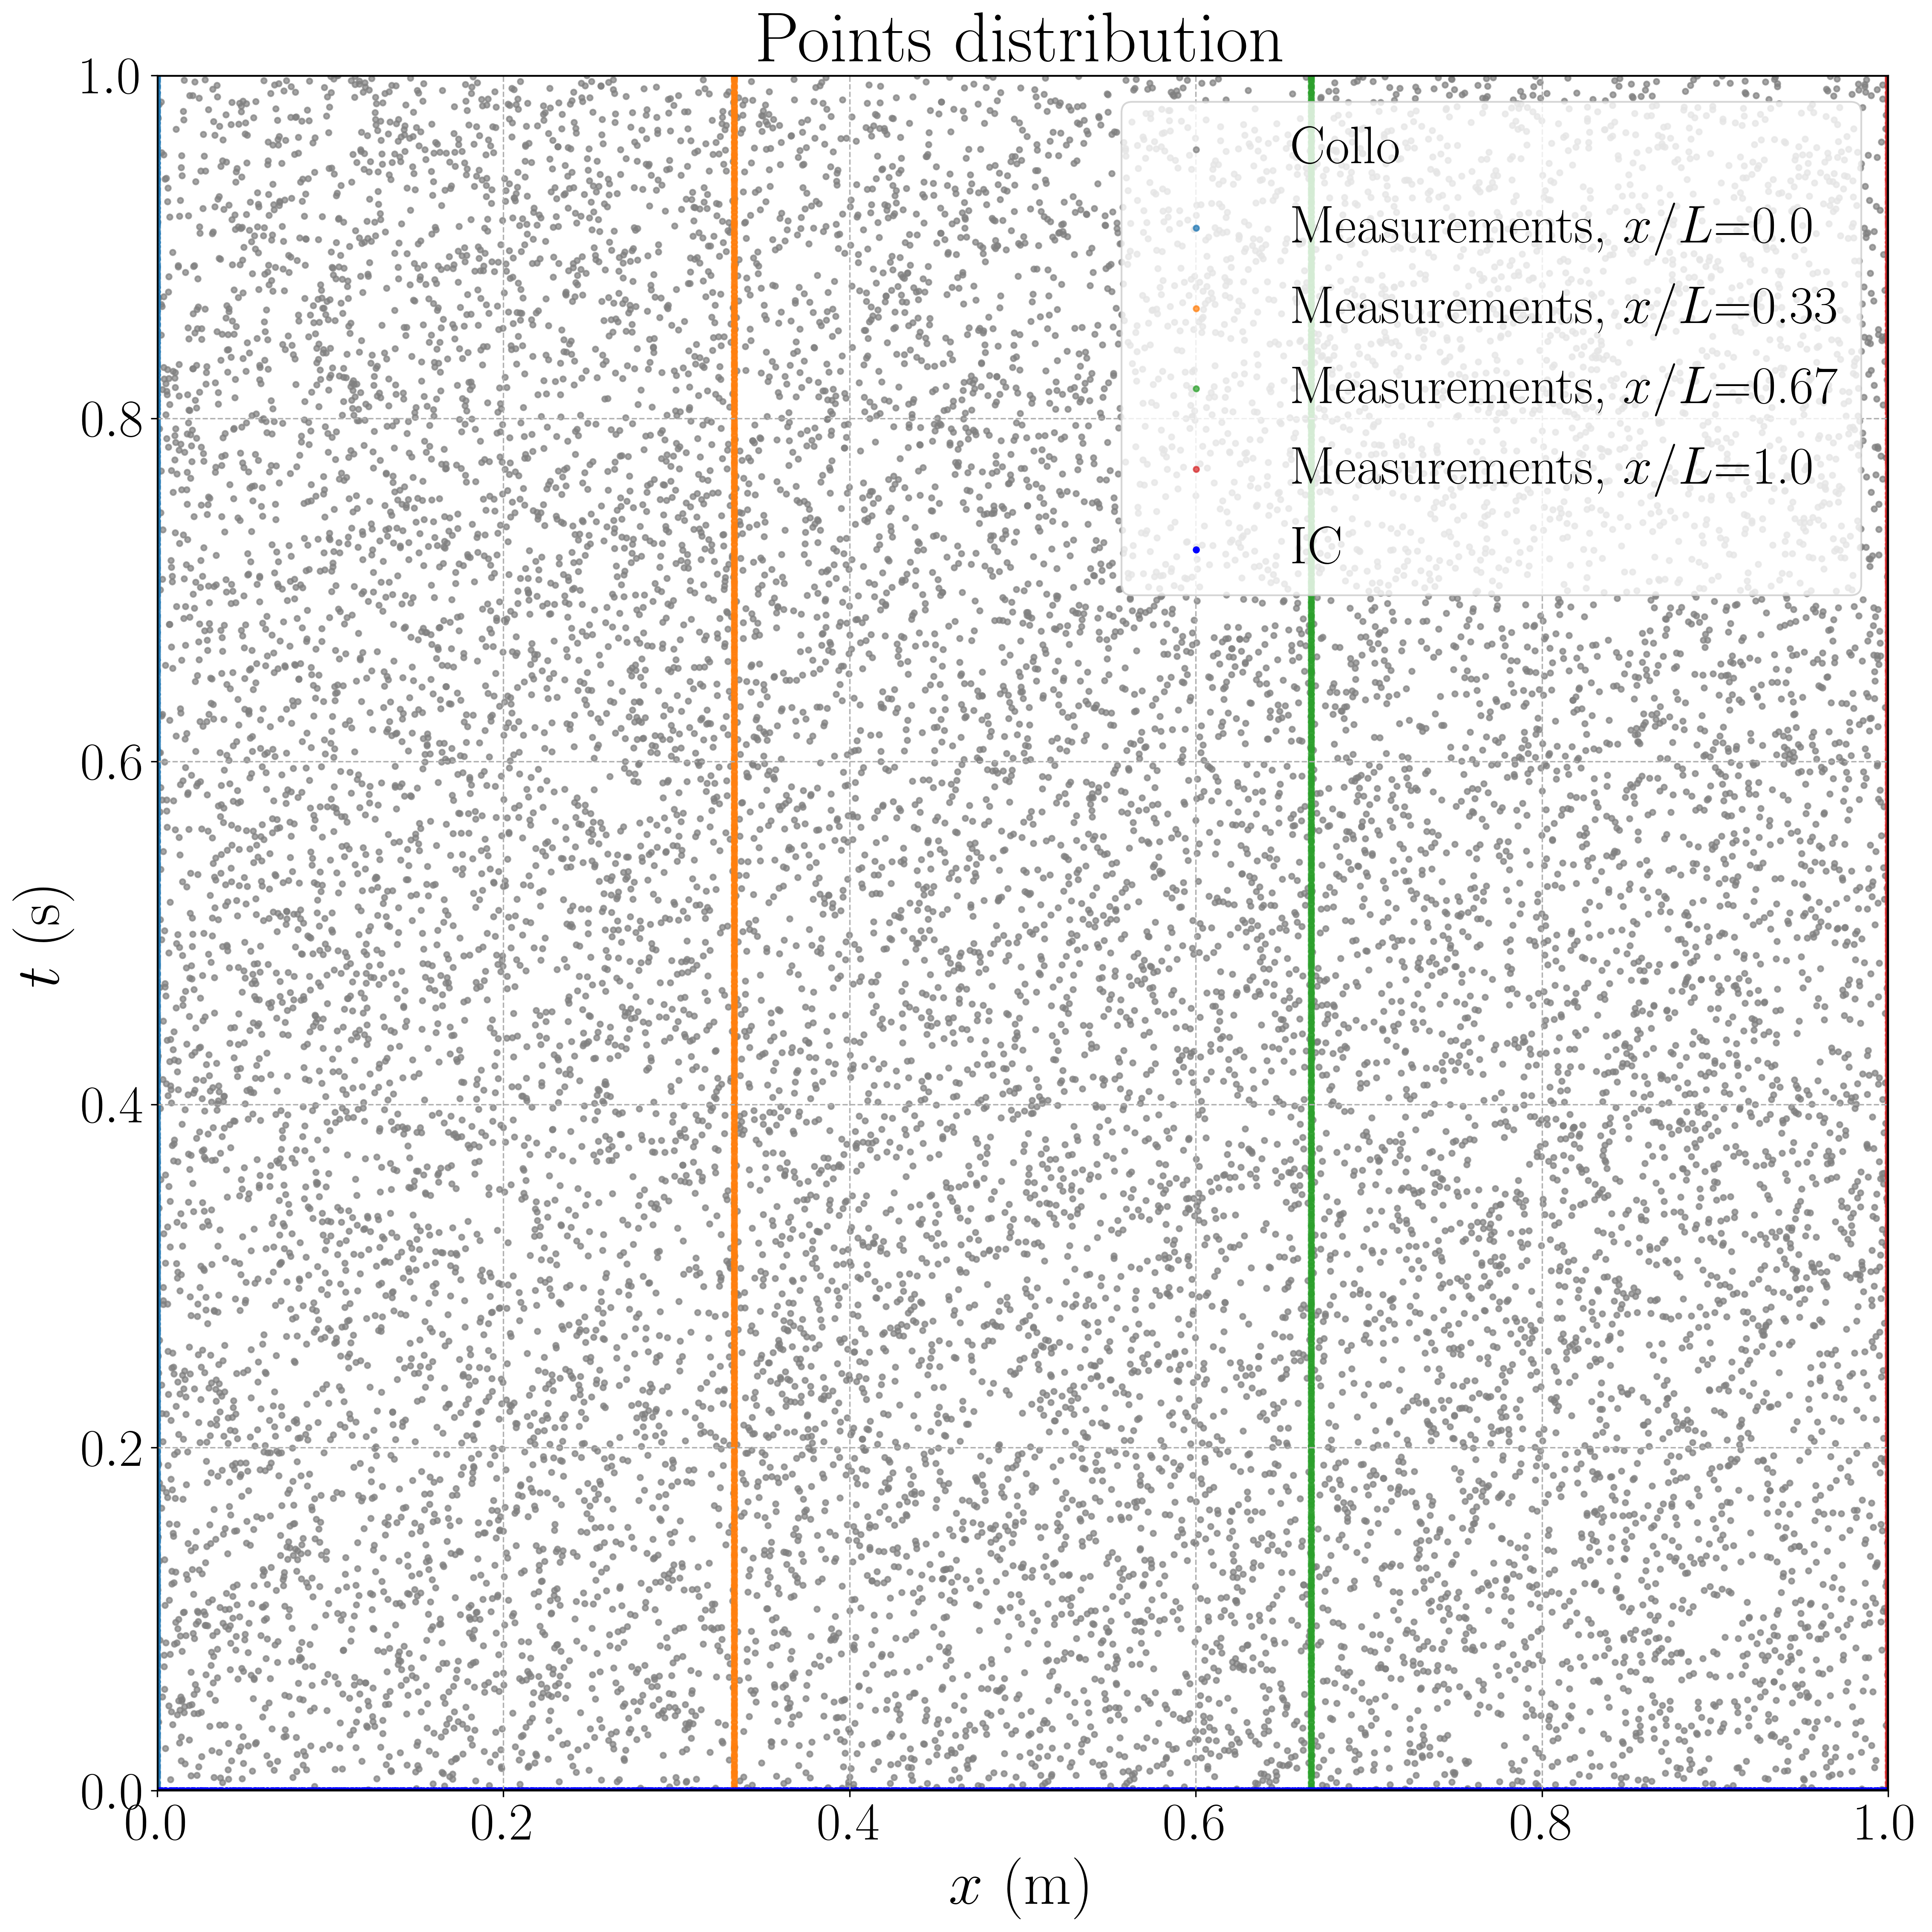

In [17]:
prob = 'Inverse'
# prob = 'Direct'

params = generate_param()

params["data"]["noise"] = 0.03
params["network"]["layers"] = [2] + 10*[5] + [2]  
case = Conduction(add_noise=True)
case.generate_train_data(param=params)
case.generate_test_data(param=params)
case.plot()

##### **Run**

In [24]:
# Create Model Instance
model = Pinn(data=case.data,
                params=params, problem_type=prob, skip_connection=True)
              #  exist_model=True, file_dir='/content/poiseuille-vp.pickle')

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1



In [25]:
# Fit using ADAM
# model.fit_adam()
model.fit_newton()

iter: 100, Loss Test: 7.1067e-02, Loss Total: 1.4831e+00, Loss Collo: 1.6247e-02, Loss Measurement: 1.1094e+00, Loss Init: 3.5748e-01
iter: 200, Loss Test: 3.4524e-02, Loss Total: 1.4605e+00, Loss Collo: 1.4553e-03, Loss Measurement: 1.1017e+00, Loss Init: 3.5735e-01
iter: 300, Loss Test: 3.0128e-02, Loss Total: 1.4572e+00, Loss Collo: 1.6045e-04, Loss Measurement: 1.1006e+00, Loss Init: 3.5638e-01
iter: 400, Loss Test: 2.3042e-02, Loss Total: 1.4568e+00, Loss Collo: 5.7695e-05, Loss Measurement: 1.1005e+00, Loss Init: 3.5620e-01
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1.456781
  Number of iterations: 357
  Number of functions evaluations: 412


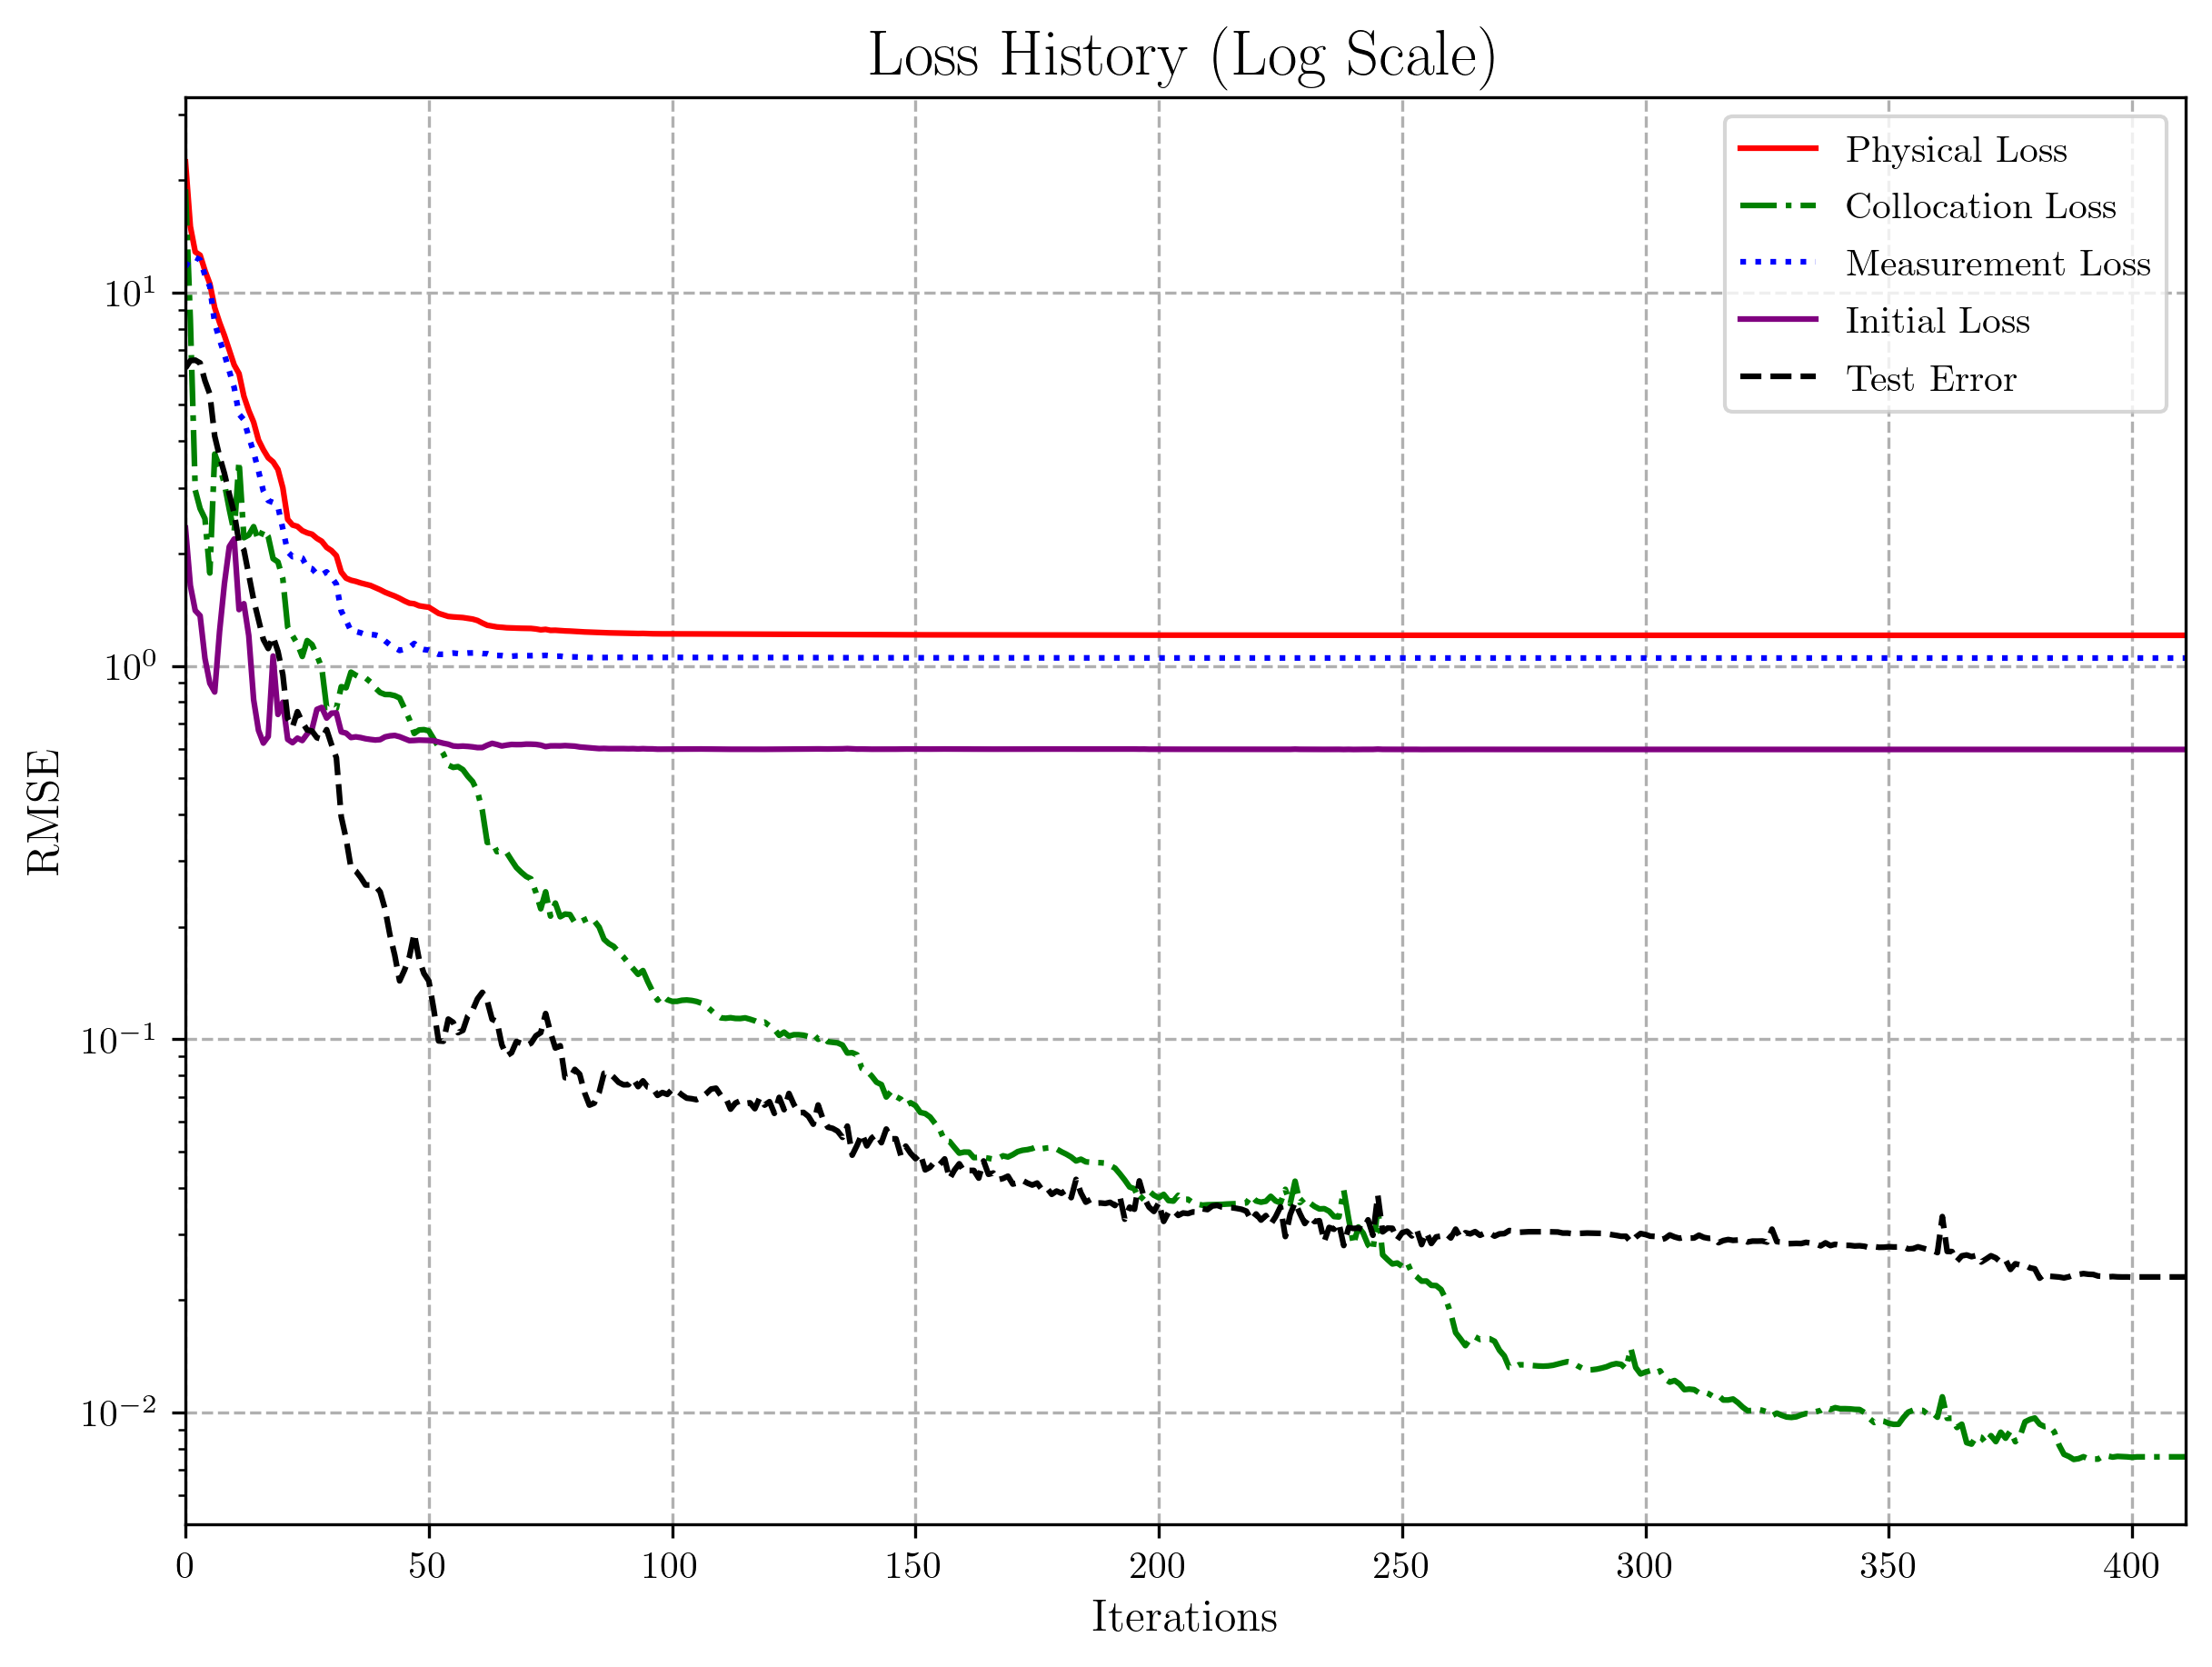

- Last Iterations: 411
- Absolute Error: 0.017805
- Relative Error (%): 0.662310
Absolute Error Lambda: 0.116755
Relative Error Lambda (%): 1.408333
RMSE lambda: 0.242457
R2 (%): 99.542647


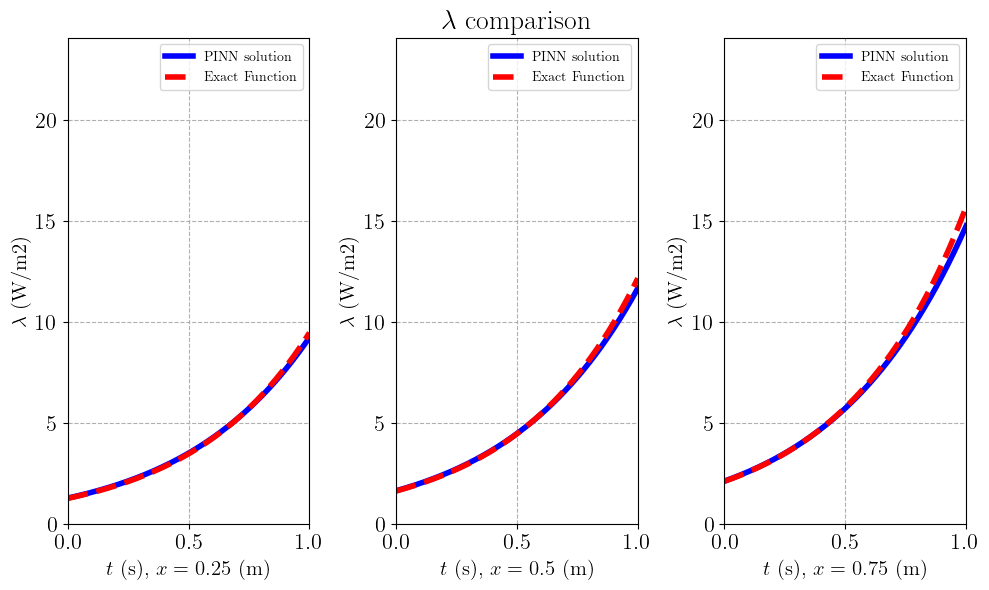

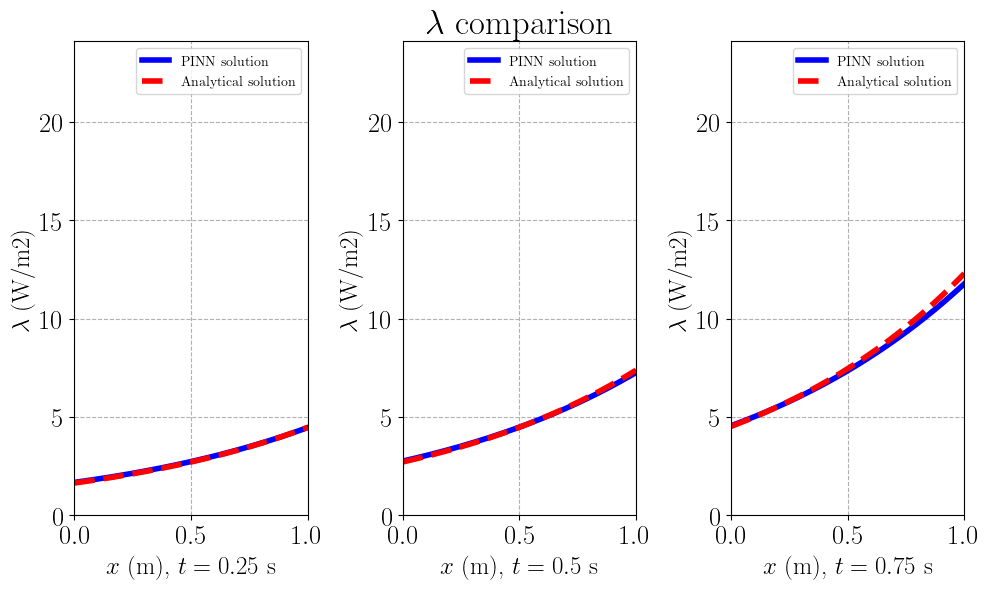

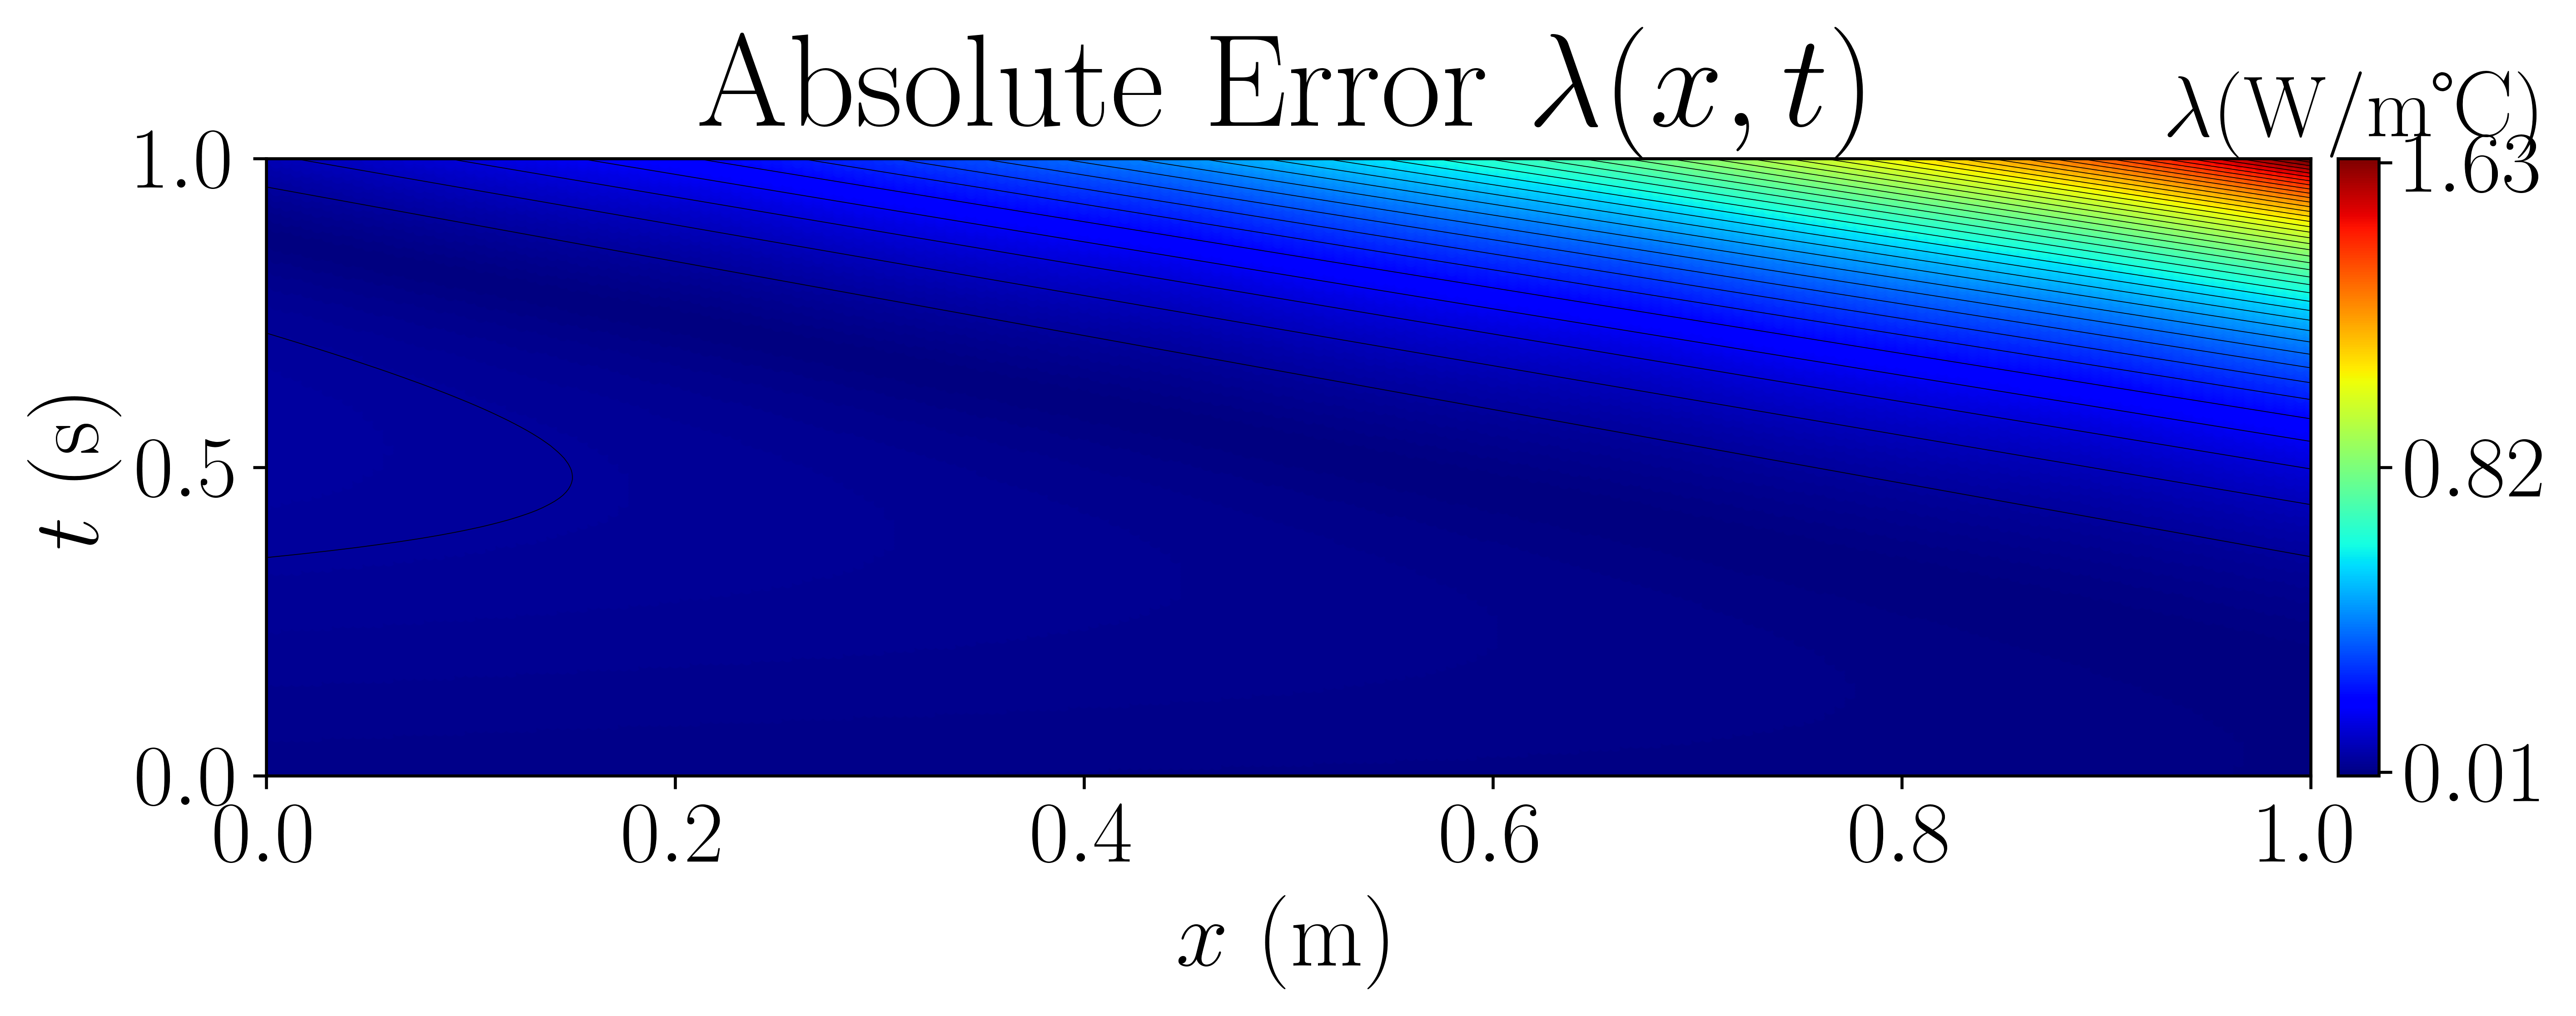

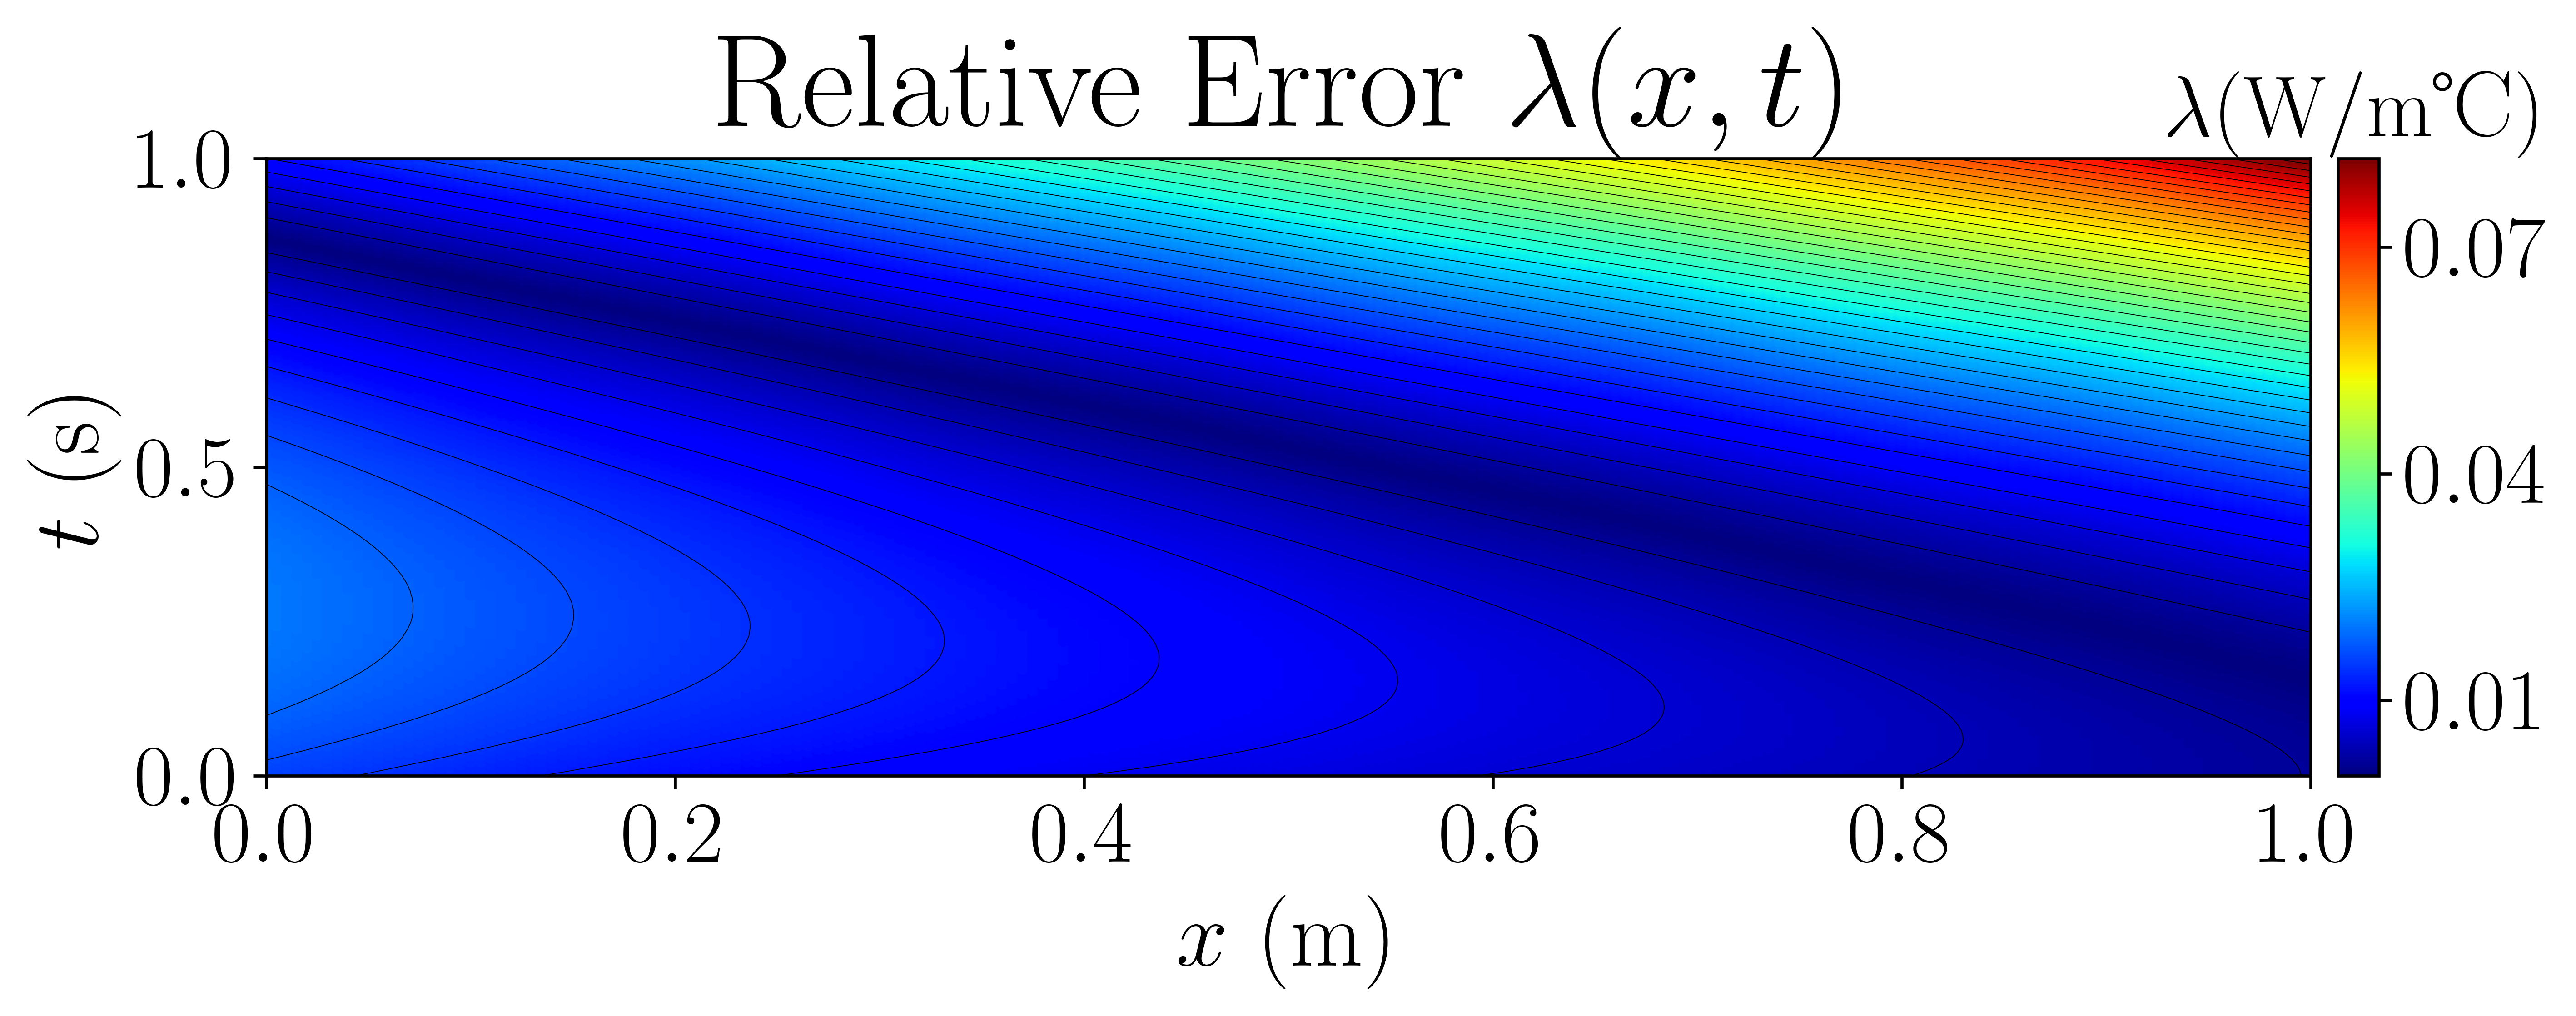

In [28]:
# Create Results
results = PostProcessing(model=model,
                      params=params,
                      save_fig=False)

results.display_loss()
results.display_contour()

# Save model
# model.save_model('test-seed=1-after.pickle')